# Uvod
Pošto sada znamo format podataka sa kojima baratamo, hajde da sada upoređujemo više različitih datasetova, naime hajde da uporedimo datasetove sa trka u Meksiku, Brazilu i Monaku. Kao i uvijek prvo što radimo jeste importovanje iz DBFS-a, sada učitavamo 3 fajla koji odgovaraju trkama.

In [0]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName("Telemetry Analysis").getOrCreate()

data_path1 = "dbfs:/FileStore/combined_telemetry_meeting_9625-1.csv"
data_path2 = "dbfs:/FileStore/combined_telemetry_meeting_9636-1.csv"
data_path3 = "dbfs:/FileStore/combined_telemetry_meeting_9523-1.csv"
data_path4 = "dbfs:/FileStore/combined_telemetry_meeting_9590-1.csv"
mexico = spark.read.csv(data_path1, header=True, inferSchema=True)
brazil = spark.read.csv(data_path2, header=True, inferSchema=True)
monaco = spark.read.csv(data_path3, header=True, inferSchema=True)
#monza = spark.read.csv(data_path4,header=True,inferSchema=True)

Nakon što smo ih učitali, sada ćemo da nacrtamo naše staze (ovdje smo mogli da koristimo priložene GEOJSON fajlove ili možemo samo da crtamo podatke iz jednog kruga jednog vozača, u ovom slučaju LeClerca krug broj 5).

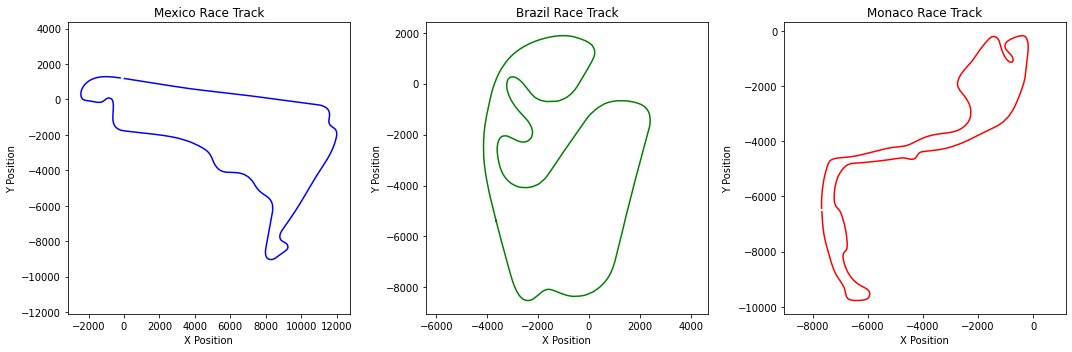

In [0]:
import matplotlib.pyplot as plt

mexico_driver_16 = mexico.filter(mexico["driver_number"] == 16).filter(mexico["lap_number"] == 5)
brazil_driver_16 = brazil.filter(brazil["driver_number"] == 16).filter(brazil["lap_number"] == 5)
monaco_driver_16 = monaco.filter(monaco["driver_number"] == 16).filter(monaco["lap_number"] == 5)

mexico_driver_16_pd = mexico_driver_16.select("X", "Y").toPandas()
brazil_driver_16_pd = brazil_driver_16.select("X", "Y").toPandas()
monaco_driver_16_pd = monaco_driver_16.select("X", "Y").toPandas()

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].plot(mexico_driver_16_pd['X'], mexico_driver_16_pd['Y'], label="Track", color="blue")
axes[0].set_title("Mexico Race Track")
axes[0].set_xlabel("X Position")
axes[0].set_ylabel("Y Position")
axes[0].axis("equal")

axes[1].plot(brazil_driver_16_pd['X'], brazil_driver_16_pd['Y'], label="Track", color="green")
axes[1].set_title("Brazil Race Track")
axes[1].set_xlabel("X Position")
axes[1].set_ylabel("Y Position")
axes[1].axis("equal")

axes[2].plot(monaco_driver_16_pd['X'], monaco_driver_16_pd['Y'], label="Track", color="red")
axes[2].set_title("Monaco Race Track")
axes[2].set_xlabel("X Position")
axes[2].set_ylabel("Y Position")
axes[2].axis("equal")

plt.tight_layout()
plt.show()


Okej, sem što su različitih boja, možemo da uočimo da su staze dosta zanimljivih oblika, neke imaju više krivina dok neke imaju više ravnina.

Hajde da analiziramo neke logičnosti, naime: staza koja ima više ravnina će biti brža od one koja ima više krivina. Ovo je zato što ravni dijelovi staze omogućavaju vozačima da postignu veće brzine, dok krivine zahtjevaju smanjenje brzine kako bi se izbegli gubici kontrole vozila. Na stazi sa mnogo krivina, brzina mora da bude niža kako bi se održala stabilnost i kontrola tokom ulaska i izlaska iz svake krivine.

Međutim, ovo nije uvek striktno pravilo, jer faktori poput širine staze, tipa guma, i vremena mogu značajno uticati na performanse na različitim dijelovima staze.

##Treća Analiza: Razlika u brzinama na stazi
### Ideja:
Ova analiza ispituje razlike u maksimalnim brzinama vozača na tri različite staze: Meksiko, Brazil i Monako. Koristimo ANOVA test da bismo utvrdili da li postoje značajne razlike između prosječnih brzina na tim stazama. Ako ANOVA pokaže značajne razlike, dodatno primjenjujemo Tukey HSD test kako bismo identifikovali između kojih staza postoje te razlike.

### Hipoteze
- Null hipoteza (H₀): Nema značajne razlike u prosječnim brzinama između staza Meksiko, Brazil i Monako. Drugim riječima, brzina vozača ne zavisi od staze.
- Alternativna hipoteza (H₁): Postoji barem jedna značajna razlika u prosječnim brzinama između staza, što znači da staza utiče na brzinu vozača.

ANOVA F-statistic: 24689.040768685914
ANOVA p-value: 0.0
Postoje itekako znacajne razlike.
 Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj  lower    upper   reject
-----------------------------------------------------
Brazil Mexico  54.2665  -0.0    53.69  54.8429   True
Brazil Monaco  21.7381  -0.0  21.1197  22.3564   True
Mexico Monaco -32.5284  -0.0 -33.1393 -31.9175   True
-----------------------------------------------------


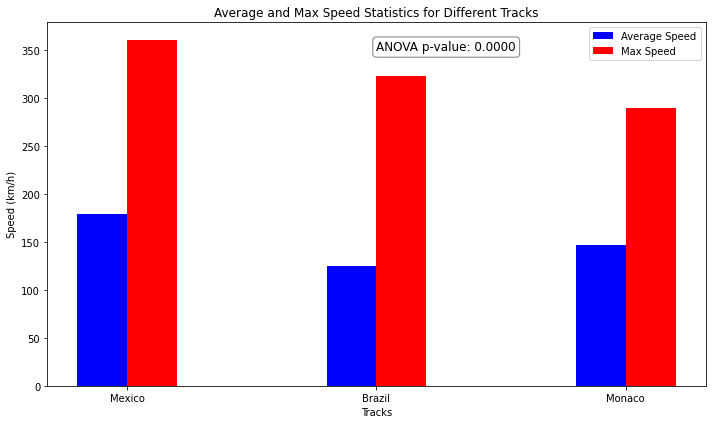

In [0]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import f_oneway
from statsmodels.stats.multicomp import pairwise_tukeyhsd

mexico_driver_max_speed = mexico.select("speed").toPandas()["speed"]
brazil_driver_max_speed = brazil.select("speed").toPandas()["speed"]
monaco_driver_max_speed = monaco.select("speed").toPandas()["speed"]

mexico_driver_max_speed = pd.to_numeric(mexico_driver_max_speed, errors="coerce")
brazil_driver_max_speed = pd.to_numeric(brazil_driver_max_speed, errors="coerce")
monaco_driver_max_speed = pd.to_numeric(monaco_driver_max_speed, errors="coerce")

mexico_driver_max_speed = mexico_driver_max_speed.dropna()
brazil_driver_max_speed = brazil_driver_max_speed.dropna()
monaco_driver_max_speed = monaco_driver_max_speed.dropna()

def calculate_stats(speed_data):
    return {
        "avg": np.mean(speed_data),
        "max": np.max(speed_data),
    }

mexico_stats = calculate_stats(mexico_driver_max_speed)
brazil_stats = calculate_stats(brazil_driver_max_speed)
monaco_stats = calculate_stats(monaco_driver_max_speed)

#ANOVA dio
f_statistic, p_value = f_oneway(mexico_driver_max_speed, brazil_driver_max_speed, monaco_driver_max_speed)
f_statistic, p_value = f_oneway(mexico_driver_max_speed, brazil_driver_max_speed, monaco_driver_max_speed)

print(f"ANOVA F-statistic: {f_statistic}")
print(f"ANOVA p-value: {p_value}")

if p_value < 0.05:
    print("Postoje itekako znacajne razlike.")
else:
    print("Nema znacajnih razlika u postignutim brzinama na stazama.")

# Tukey HSD dio
if p_value < 0.05:
    data = pd.DataFrame({
        "speed": np.concatenate([mexico_driver_max_speed, brazil_driver_max_speed, monaco_driver_max_speed]),
        "track": ["Mexico"] * len(mexico_driver_max_speed) + 
                 ["Brazil"] * len(brazil_driver_max_speed) + 
                 ["Monaco"] * len(monaco_driver_max_speed)
    })

    tukey_results = pairwise_tukeyhsd(data["speed"], data["track"])
    print(tukey_results)

tracks = ["Mexico", "Brazil", "Monaco"]
stats = [mexico_stats, brazil_stats, monaco_stats]

fig, ax = plt.subplots(figsize=(10, 6))

bar_width = 0.2
x = np.arange(len(tracks))

ax.bar(x - bar_width/2, [s["avg"] for s in stats], width=bar_width, label="Average Speed", color="blue")
ax.bar(x + bar_width/2, [s["max"] for s in stats], width=bar_width, label="Max Speed", color="red")

ax.set_xlabel("Tracks")
ax.set_ylabel("Speed (km/h)")
ax.set_title("Average and Max Speed Statistics for Different Tracks")
ax.set_xticks(x)
ax.set_xticklabels(tracks)
ax.legend()

ax.text(0.5, 0.95, f"ANOVA p-value: {p_value:.4f}", transform=ax.transAxes, fontsize=12, 
        verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))

plt.tight_layout()
plt.show()

### Zaključak:
ANOVA test je dao F-statistiku = 24689.04 i p-vrijednost = 0.0, što znači da je p-vrijednost manja od 0.05.
Budući da je p-vrijednost znatno ispod 0.05, odbijamo null hipotezu (H₀) i zaključujemo da postoje značajne razlike u prosječnim brzinama između staza.
Tukey HSD test je pokazao da su sve tri staze statistički različite po prosječnim brzinama:
Meksiko ima znatno veće brzine od Brazila (razlika +54.27 km/h).
Brazil ima znatno veće brzine od Monaka (razlika +21.74 km/h).
Meksiko ima znatno veće brzine od Monaka (razlika +32.53 km/h).
Najveće brzine se postižu u Meksiku, dok su najniže brzine u Monaku, što je u skladu s očekivanjima zbog konfiguracije staza.
### Rezultat:
Na osnovu rezultata ANOVA testa i Tukey HSD testa, potvrđeno je da prosječne brzine vozača značajno variraju u zavisnosti od staze. Najbrža staza je Meksiko, dok je Monako najsporija. Ovi rezultati su u skladu s razlikama u dužini pravaca i tehničkom zahtjevnošću svake staze. 

Na osnovu dobijenog hajde da pogledamo zapravo od čega zavisi naša brzina ili ostale metrike telemetrije, to ćemo postići koristeći korelacionu matricu koja će nam reći kolika je korelacija između nekih polja. (od -1 do 1, što bliže 1 znači da postoji neki tip zavisnosti, dok što bliže -1, znači neki tip odbojnosti, isto korisno). Bitno je uočiti da je prosječna brzina u Brazilu neobično mala cifra...

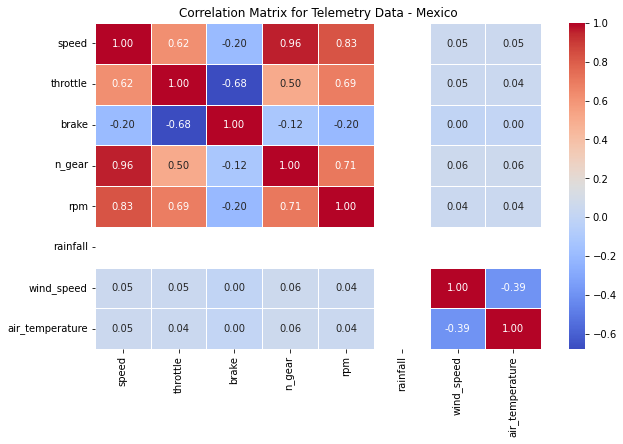

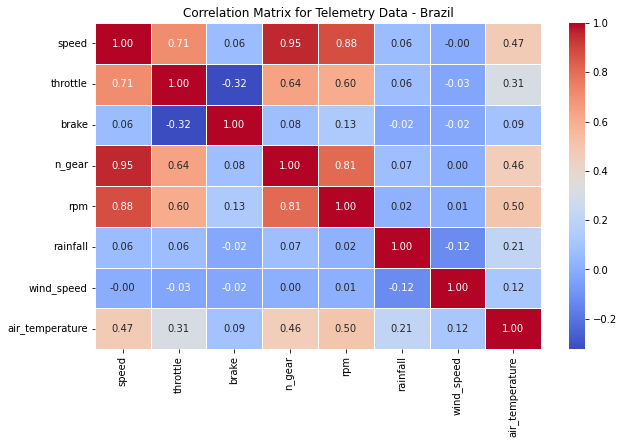

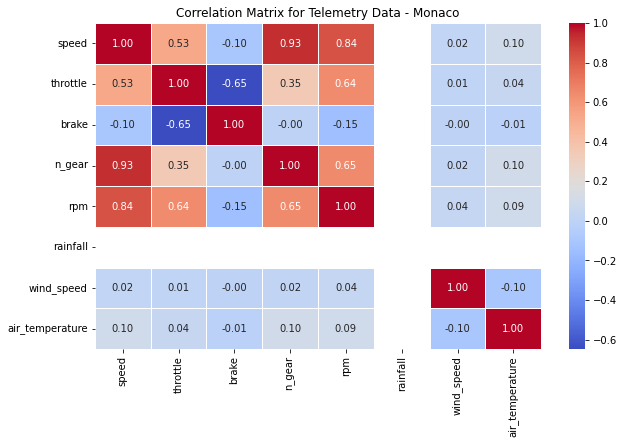

In [0]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

mexico_df = mexico.toPandas()
brazil_df = brazil.toPandas()
monaco_df = monaco.toPandas()

columns_of_interest = ["speed", "throttle", "brake", "n_gear", "rpm", "rainfall", "wind_speed","air_temperature"]

mexico_correlation_matrix = mexico_df[columns_of_interest].corr()

plt.figure(figsize=(10, 6))
sns.heatmap(mexico_correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix for Telemetry Data - Mexico")
plt.show()

brazil_correlation_matrix = brazil_df[columns_of_interest].corr()

plt.figure(figsize=(10, 6))
sns.heatmap(brazil_correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix for Telemetry Data - Brazil")
plt.show()

monaco_correlation_matrix = monaco_df[columns_of_interest].corr()

plt.figure(figsize=(10, 6))
sns.heatmap(monaco_correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix for Telemetry Data - Monaco")
plt.show()


Ovdje je uočljivo da je tokom trke u Brazilu padala kiša, što objašnjava zašto smo na gornjem grafikonu primijetili neuobičajeno malu prosječnu brzinu na toj stazi. Pošto znamo da je Brazil outlier, za dalju vizualizaciju ćemo uzeti ekstrema Monaka i Meksika kako bismo mogli detaljnije analizirati podatke.

Što se tiče sadržaja matrice korelacije, vidimo nekoliko logičnih odnosa: RPM, broj stepena prenosa (n_gear), throttle i brzina (speed) su međusobno snažno povezani, dok je prisustvo kočnice obrnuto proporcionalno ovim parametrima, što je i očekivano.

Takođe, prisustvo redova i kolona koji označavaju kišu sugeriše da je na nekoj stazi bilo padavina tokom trke. Vidimo i intuitivne veze između atmosferskih faktora kao što su vjetar, kiša i temperatura, mada ovi parametri mogu značajno zavisiti i od lokalnih meteoroloških prilika.

## Četvrta analiza: Uporedimo performanse jednog motora na dvije različite staze
### Ideja:
Uporedićemo RPM metriku sa brzinom koju bolid dostiže u tom trenutku i označiti tačke na osnovu brzine pogona u kojem se nalazi. Ideja je da uporedimo dvije staze – Monako i Meksiko – jer su potpuno različite. Jedna se nalazi na 2700 mnv, dok je druga na samo 5 mnv.(mnv -> Metara Nadmorske Visine) Takođe, raspored krivina, prosječne i maksimalne brzine su potpuno drugačije, što ih čini idealnim za test.

Koristićemo Levenov statistički test za varijansu na osnovu RPM metrike kako bismo analizirali razlike.

### Hipoteze:
- Nulta hipoteza (H₀): Nema značajne razlike – motor jednog vozača će se ponašati isto na obe staze. Jedino očekivano odstupanje bi moglo biti povećan broj podataka u određenim područjima, što bi značilo da je bolid duže vrijeme proveo na istim podešavanjima RPM-a i brzine pogona.

- Alternativna hipoteza (H₁): Postoje značajne razlike – raspodjela podataka će biti velika, što znači da je vozač mogao koristiti određeni RPM i brzinu pogona na jednoj stazi, dok mu to na drugoj nije bilo omogućeno.

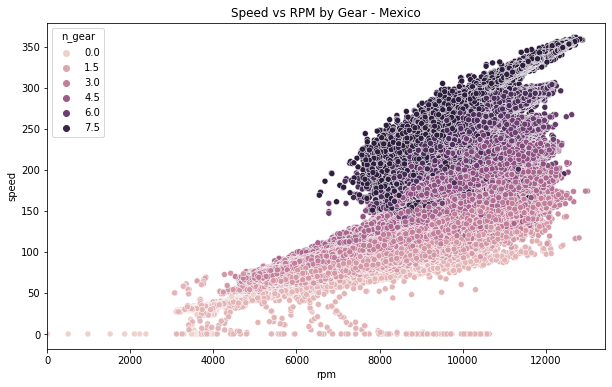

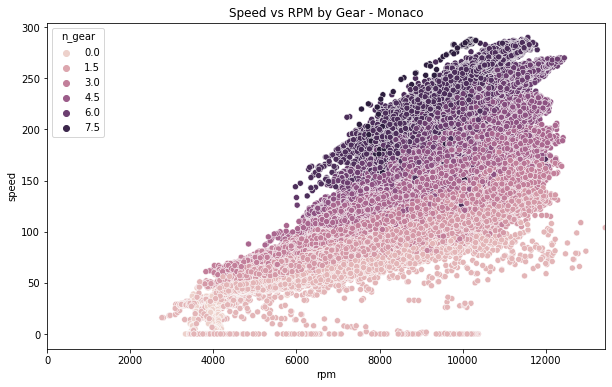

Levene's Test Results:
Statistic: 530.0685195043799
P-value: 3.240268701773951e-117
Varijanse su itekako razlicite (p < 0.05).


In [0]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import levene

x_min = min(mexico_df['rpm'].min(), monaco_df['rpm'].min())
x_max = max(mexico_df['rpm'].max(), monaco_df['rpm'].max())

plt.figure(figsize=(10, 6))
sns.scatterplot(x='rpm', y='speed', hue='n_gear', data=mexico_df)
plt.xlim(x_min, x_max)  
plt.title("Speed vs RPM by Gear - Mexico")
plt.show()

plt.figure(figsize=(10, 6))
sns.scatterplot(x='rpm', y='speed', hue='n_gear', data=monaco_df)
plt.xlim(x_min, x_max) 
plt.title("Speed vs RPM by Gear - Monaco")
plt.show()

levene_test_result = levene(mexico_df['rpm'], monaco_df['rpm'])

print("Levene's Test Results:")
print(f"Statistic: {levene_test_result.statistic}")
print(f"P-value: {levene_test_result.pvalue}")

if levene_test_result.pvalue < 0.05:
    print("Varijanse su itekako razlicite (p < 0.05).")
else:
    print("Varijanse nisu pretjerno razlicite (p >= 0.05).")

### Zaključak:
Postoji itekako ogromna razlika, što nam jasno pokazuje grafikon, a Levenov test to dodatno potvrđuje zbog izuzetno visokih vrijednosti. Ono što možemo zaključiti jeste da se jedan motor ne koristi u istom režimu snage ili pogona na dvije staze koje su potpuno različitog profila.

Ovim smo (barem za nas) dokazali postojanje mapiranja motora (Engine Maps), koja određuju koje performanse jedan motor može postići u određenim uslovima.

Sada ćemo pokušati da sprovedemo možda i najvažniju analizu tokom jednog F1 vikenda – analizu performansi guma.


## Peta analiza: Različite gume daju različite brzine krugova
### Ideja:
Cilj ove analize je ispitati da li različiti tipovi guma (MEDIUM i HARD) imaju značajan uticaj na brzinu krugova vozača. (direktna analiza poput Monze)

### Hipoteze:
- Nulta hipoteza (H₀): Nema značajne razlike u vremenu krugova između MEDIUM i HARD guma.
- Alternativna hipoteza (H₁): Postoji velika razlika između MEDIUM i HARD guma

In [0]:
lap_data_pd = mexico.toPandas()
unique_tyre_compounds = lap_data_pd['tyre_compound'].unique()
print(unique_tyre_compounds)

['MEDIUM' 'HARD' 'SOFT']


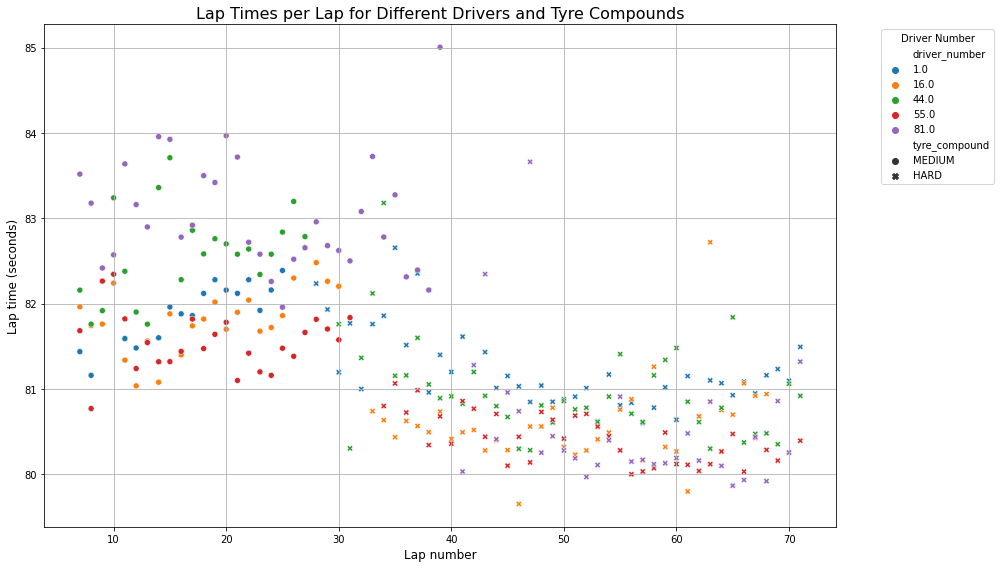

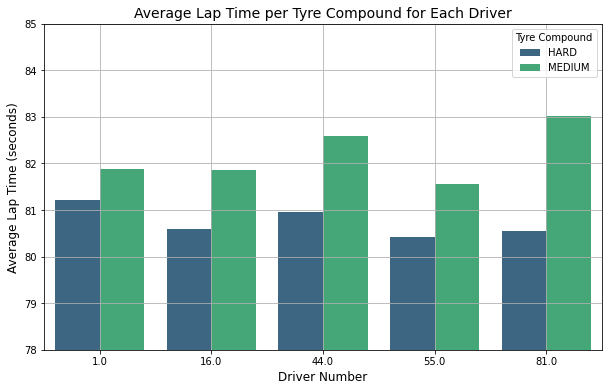


Average Lap Time Difference (Hard - Medium) per Driver:
tyre_compound  pace_diff
driver_number           
1.0            -0.669881
16.0           -1.262375
44.0           -1.620714
55.0           -1.126424
81.0           -2.476599
T-Test p-value: 0.00000
Velika razlika izmedju MEDIUM i HARD guma.


In [0]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

data = mexico.toPandas()

filtered_data = data[data['tyre_compound'].isin(['MEDIUM', 'HARD'])]

filtered_data = filtered_data.copy()
filtered_data.loc[:, 'date'] = pd.to_datetime(filtered_data['date'])

filtered_data = filtered_data.sort_values(by=['driver_number', 'lap_number'])

filtered_data = filtered_data.dropna(subset=['tyre_compound', 'lap_number', 'date'])

def process_driver_data(driver_number, df):
    driver_df = df[df["driver_number"] == driver_number]

    lap_times = (
        driver_df.groupby("lap_number")
        .agg(min_time=("date", "min"), max_time=("date", "max"), tyre_compound=("tyre_compound", "first"))
        .reset_index()
    )

    lap_times["lap_time"] = (lap_times["max_time"] - lap_times["min_time"]).dt.total_seconds()
    lap_times["driver_number"] = driver_number

    Q1 = lap_times["lap_time"].quantile(0.25)
    Q3 = lap_times["lap_time"].quantile(0.75)
    IQR = Q3 - Q1
    filtered_lap_times = lap_times[
        (lap_times["lap_time"] >= (Q1 - 1.5 * IQR)) & (lap_times["lap_time"] <= (Q3 + 1.5 * IQR))
    ]

    return filtered_lap_times

driver_numbers = filtered_data['driver_number'].unique()
processed_data = pd.concat([process_driver_data(driver, filtered_data) for driver in driver_numbers])

plt.figure(figsize=(14, 8))
sns.scatterplot(
    data=processed_data,
    x='lap_number',
    y='lap_time',
    hue='driver_number',
    style='tyre_compound',
    palette='tab10'
)
plt.title("Lap Times per Lap for Different Drivers and Tyre Compounds", fontsize=16)
plt.xlabel("Lap number", fontsize=12)
plt.ylabel("Lap time (seconds)", fontsize=12)
plt.legend(title="Driver Number", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

driver_avg_pace = processed_data.groupby(['driver_number', 'tyre_compound'])['lap_time'].mean().reset_index()

plt.figure(figsize=(10, 6))
sns.barplot(
    data=driver_avg_pace,
    x='driver_number',
    y='lap_time',
    hue='tyre_compound',
    palette='viridis'
)
plt.ylim(78,85)
plt.title("Average Lap Time per Tyre Compound for Each Driver", fontsize=14)
plt.xlabel("Driver Number", fontsize=12)
plt.ylabel("Average Lap Time (seconds)", fontsize=12)
plt.legend(title="Tyre Compound")
plt.grid(True)
plt.show()

pace_diffs = driver_avg_pace.pivot(index='driver_number', columns='tyre_compound', values='lap_time')
pace_diffs['pace_diff'] = pace_diffs['HARD'] - pace_diffs['MEDIUM']
print("\nAverage Lap Time Difference (Hard - Medium) per Driver:")
print(pace_diffs[['pace_diff']])

medium_times = processed_data[processed_data['tyre_compound'] == 'MEDIUM']['lap_time'].dropna()
hard_times = processed_data[processed_data['tyre_compound'] == 'HARD']['lap_time'].dropna()

if len(medium_times) > 1 and len(hard_times) > 1:
    t_test_result = stats.ttest_ind(medium_times, hard_times, equal_var=False)
    print(f"T-Test p-value: {t_test_result.pvalue:.5f}")
    if t_test_result.pvalue < 0.05:
        print("Velika razlika izmedju MEDIUM i HARD guma.")
    else:
        print("Nema razlike.")
else:
    print("Nema podataka o gumama")




### Rezultati:
Analiza prosječnog vremena kruga za svakog vozača pokazuje da su HARD gume u prosjeku brže od MEDIUM guma. T-test je dao veoma malu p-vrijednost (p ≈ 0.00000), što znači da je razlika statistički značajna. Ovo možda djeluje kontraintuitivno, ali postoji logično objašnjenje.

Objašnjenje:
- Temperatura guma – HARD gume mogu raditi optimalnije ako su temperature visoke, dok MEDIUM gume mogu pregrijati i gubiti performanse.
- Tip staze – Ako je staza glatka ili zahtijeva konzistentan tempo, HARD gume mogu biti bolji izbor zbog manje degradacije i boljeg trajanja kroz više krugova.
### Zaključak:
Pošto je p-vrijednost ekstremno mala, možemo odbaciti nultu hipotezu i potvrditi da HARD gume u ovom slučaju pružaju bolje performanse od MEDIUM guma.